In [452]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pykrx import stock

# Delta 계산시, imvol로 써야할지? 아니면 변하는 현실 변동성으로 써야할지 고민.

# Class 정의

In [681]:
from scipy.stats import norm

class real_delta_hedging ():

    def __init__ (self, df, strike_ratio, option_premium, num_shares, cost_int, sell_cost):
        '''input df with columns s0, q, r, vol, tau'''
        self.df         = df
        self.asset_name = df.columns.name

        self.s0         = df.s0.to_numpy().reshape(-1, 1)
        self.k          = self.s0[0] * ( 1 + strike_ratio )

        self.r          = df.r.to_numpy().reshape(-1, 1)
        self.q          = df.q.to_numpy().reshape(-1, 1)

        self.vol        = df.vol.to_numpy().reshape(-1, 1)
        self.sell_iv    = self.vol[0] * (1 + option_premium)
        
        #self.dt         = 1 / ((len(df)-1)/20 * 52)      # 검증시 dt 맞춰줌
        self.dt         = 1 / (len(df) * 2)              # 6개월을 기준으로 해서 두배해준것
        self.tau        = df.tau.to_numpy().reshape(-1,1) * self.dt
        
        self.num_shares = num_shares

        self.cost_int   = cost_int
        self.sell_cost  = sell_cost

    def df_for_bahn (self):

        path_delta = pd.Series(self.path_delta().reshape(-1), index=self.df.index, name='Delta')

        c_list=[]
        for x in range(len(self.df)):
            s = self.df.iloc[x][0]
            k = self.k
            q = self.df.iloc[x][1]
            r = self.df.iloc[x][2]
            vol = self.df.iloc[x][3]
            tau = self.df.iloc[x][4] * self.dt
            c_list.append(self.bsm_cal(s,k,r,q,vol,tau,'c').item())

        c_list = pd.Series(c_list, index=self.df.index, name='call_price')
        
        reg = pd.concat([self.df, path_delta, c_list], axis=1)
        return reg

    def normal_result_df (self):

        path_delta = pd.Series(self.path_delta().reshape(-1), index=self.df.index, name='Delta')

        path_delta_ch = pd.Series(self.path_changes(self.path_delta()).reshape(-1), index=self.df.index, name='Delta_ch')

        purchase_share_ch = pd.Series(self.path_changes(self.path_delta_num_shares()).reshape(-1), index=self.df.index, name='Buy Shares_ch')

        purchase_cost_ch = pd.Series(self.path_delta_cost_ch().reshape(-1), index=self.df.index, name='Buy_cost_ch/1000')/1000

        purchase_cost_with_tr = pd.Series(self.buy_cost_ch_with_tr().reshape(-1), index=self.df.index, name=f'Buy_cost_with_{self.sell_cost}_ch/1000')/1000

        cum_cost = pd.Series(self.cum_cost_ch_with_int()[0].reshape(-1), index=self.df.index, name='Cum_cost/1000')/1000

        int_cost = pd.Series(self.cum_cost_ch_with_int()[1].reshape(-1), index=self.df.index, name='int_cost')

        reg = pd.concat([self.df.s0, path_delta, path_delta_ch, purchase_share_ch, purchase_cost_ch, purchase_cost_with_tr, cum_cost, int_cost], axis=1)

        return reg
    
    def normal_result_plot (self, size='small'):

        if size == 'big':
            size = (14,21)
        elif size == 'middle':
            size = (8, 12)
        elif size == 'small':
            size = (6, 9)
        else:
            size = (4, 6)

        reg = self.normal_result_df()

        plt.figure(figsize=size, dpi=400)
        plt.subplot(3, 1, 1)
        plt.title(f"{self.asset_name}'s Plot", size=30)
        plt.plot(reg.s0, label='Spot Price')
        plt.legend()
        plt.grid()

        plt.subplot(3, 1, 2)
        plt.plot(reg.Delta, label='Delta')
        plt.legend()
        plt.grid()

        plt.subplot(3, 1, 3)
        plt.plot(reg[reg.columns[5]], label='Buy Cost')
        plt.legend()
        plt.grid()

        plt.show()

    def test_result_plot (self, delta_path, size='small'):

        if size == 'big':
            size = (14,21)
        elif size == 'middle':
            size = (8, 12)
        elif size == 'small':
            size = (6, 9)
        else:
            size = (4, 6)

        reg = self.test_result_df(delta_path)

        plt.figure(figsize=size, dpi=400)
        plt.subplot(3, 1, 1)
        plt.title(f"{self.asset_name}'s Plot", size=30)
        plt.plot(reg.s0, label='Spot Price')
        plt.legend()
        plt.grid()

        plt.subplot(3, 1, 2)
        plt.plot(reg.Delta, label='Delta')
        plt.plot(reg.Delta_test, label='New_Delta')
        plt.legend()
        plt.grid()

        plt.subplot(3, 1, 3)
        plt.plot(reg[reg.columns[6]], label='Buy Cost')
        plt.legend()
        plt.grid()

        plt.show()


    def test_result_df (self, delta_path):
        '''input delta_path should be (row, 1) shape'''

        path_delta = pd.Series(self.path_delta().reshape(-1), index=self.df.index, name='Delta')

        path_delta_2 = pd.Series(delta_path.reshape(-1), index=self.df.index, name='Delta_test')

        path_delta_ch = pd.Series(self.path_changes(delta_path).reshape(-1), index=self.df.index, name='Delta_ch')

        purchase_share_ch = pd.Series(self.path_changes(self.path_delta_num_shares(delta_path)).reshape(-1), index=self.df.index, name='Buy Shares_ch')

        purchase_cost_ch = pd.Series(self.path_delta_cost_ch(delta_path).reshape(-1), index=self.df.index, name='Buy_cost_ch/1000')/1000

        purchase_cost_with_tr = pd.Series(self.buy_cost_ch_with_tr(delta_path).reshape(-1), index=self.df.index, name=f'Buy_cost_with_{self.sell_cost}_ch/1000')/1000

        cum_cost = pd.Series(self.cum_cost_ch_with_int(delta_path)[0].reshape(-1), index=self.df.index, name='Cum_cost/1000')/1000

        int_cost = pd.Series(self.cum_cost_ch_with_int(delta_path)[1].reshape(-1), index=self.df.index, name='int_cost')

        reg = pd.concat([self.df.s0, path_delta, path_delta_2, path_delta_ch, purchase_share_ch, purchase_cost_ch, purchase_cost_with_tr, cum_cost, int_cost], axis=1)

        return reg

    def bsm_cal (self, s0, k, r, q, iv, tau, cpflag):

        d1 = self.d1_cal(s0, k, r, q, iv, tau)
        d2 = self.d2_cal(s0, k, r, q, iv, tau)

        if cpflag == 'c':
            return s0 * np.exp(-q * tau) * norm.cdf(d1) - self.k * np.exp(-r * tau)*norm.cdf(d2)
        elif cpflag == 'p':
            return k * np.exp(-r*tau)*norm.cdf(-d2) - s0 * np.exp(-q * tau) * norm.cdf(-d1) 
            

    def bsm_eq (self, cpflag):

        d1 = self.d1_cal(self.s0[0], self.k, self.r[0], self.q[0], self.sell_iv, self.tau[0])
        d2 = self.d2_cal(self.s0[0], self.k, self.r[0], self.q[0], self.sell_iv, self.tau[0])
        
        if cpflag == 'c':
            return self.s0[0] * np.exp(-self.q[0] * self.tau[0]) * norm.cdf(d1) - self.k * np.exp(-self.r[0] * self.tau[0])*norm.cdf(d2)
        elif cpflag == 'p':
            return self.k * np.exp(-self.r[0]*self.tau[0])*norm.cdf(-d2) - self.s0[0] * np.exp(-self.q[0] * self.tau[0]) * norm.cdf(-d1) 
            
    def path_delta(self):

        delta = norm.cdf(self.d1_cal(self.s0, self.k, self.r, self.q, self.sell_iv, self.tau))
        
        return delta

    def path_changes (self, path):

        return np.vstack([path[0], path[1:] - path[:-1]])

    def path_delta_num_shares (self, delta_path=None):

        if delta_path is None:
            delta_path = self.path_delta()
        else:
            pass
    
        return delta_path * self.num_shares

    def path_delta_cost_ch (self, delta_path=None):

        if delta_path is None:
            path = self.path_changes(self.path_delta_num_shares())
        else:
            pass
            path = self.path_changes(self.path_delta_num_shares(delta_path))

        return path * self.s0

    def buy_cost_ch_with_tr (self, delta_path=None):

        if delta_path is None:
            path = self.path_delta_cost_ch()
        else:
            pass
        
            path = self.path_delta_cost_ch(delta_path)

        path = np.where(path < 0, path * (1+self.sell_cost), path)

        return path

    def cum_cost_ch_with_int (self, delta_path=None):
    
        if delta_path is None:
            cost_tr = self.buy_cost_ch_with_tr()
        else:
            cost_tr = self.buy_cost_ch_with_tr(delta_path)

        upper = (self.cost_int * self.dt)

        cost_tr_reg = np.repeat(cost_tr[0], self.s0.shape[0]).reshape(-1, self.s0.shape[1])
        int_reg     = np.repeat(cost_tr[0] * upper, self.s0.shape[0]).reshape(-1, self.s0.shape[1])

        for x in range(0, self.s0.shape[1]):
        
            for idx in range(self.s0[:,x].shape[0]-1):
                cost_tr_reg[idx+1, x] = cost_tr_reg[idx,x] * (1+upper) + cost_tr[idx+1, x]
                int_reg[idx+1, x] = cost_tr_reg[idx,x] * upper
        
        return cost_tr_reg, int_reg, upper

    def hedging_cost_reg (self, delta_path=None):
        if delta_path is None:
            cost = self.cum_cost_ch_with_int()[0][-1].item()
        
        else:
            cost = self.cum_cost_ch_with_int()[0][-1].item()

        print(f'Hedging Cost : {cost}')

    def d1_cal (self, s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))

    def d2_cal (self, s, k, r, q, vol, t):
        return self.d1_cal(s, k, r, q, vol, t) - vol * np.sqrt(t)

    def simulation (self, simul=10000):
        '''simul = 10000 default'''

        mu      = self.r[0]
        r      = self.r[0]
        q       = self.q[0]
        sigma   = self.vol[0]
        dt      = self.dt
        s0      = self.s0[0]

        tau_arr = (np.flip(np.arange(0, len(self.df)+1)) * dt).reshape(-1,1)

        value = np.ones((2, simul)) * s0

        for idx in range(1, len(self.df)+1):
            d_term = (mu - q - 0.5 * sigma**2) * dt
            s_term = sigma * np.sqrt(dt) * np.random.normal(size=(simul))

            value = np.vstack([value, value[-1] * np.exp(d_term + s_term)])
        
        stock_path = value[1:]

        delta = norm.cdf(self.d1_cal(stock_path, self.k, r, q, sigma, tau_arr))
        
        path_arr = np.vstack([delta[0], (delta[1:] - delta[:-1])])

        arr = (path_arr * stock_path)
        arr = np.where(arr>0, arr*(1+self.sell_cost), arr)

        hedge_arr = ( arr * np.exp(r * tau_arr)).cumsum(axis=0)[-1]
        hedge_arr = np.where(hedge_arr > self.k, hedge_arr - self.k, hedge_arr)

        return hedge_arr

## 검증 완료!

In [668]:

# a = np.array([49, 48.125, 47.375, 50.25, 51.75, 53.125, 53, 51.875, 51.375, 53, 49.875, 48.5, 49.875, 50.375, 52.125, 51.875, 52.875, 54.875, 54.625, 55.875, 57.25])
# qqq = np.array([0 for x in range(len(a))])
# rrr = np.array([0.05 for x in range(len(a))])
# vol = np.array([0.2 for x in range(len(a))])
# tau = np.flip(np.arange(0, len(a)))

# valdf = pd.DataFrame([a,qqq,rrr,vol,tau], index=['s0','q', 'r','vol','tau']).T

# val = real_delta_hedging(valdf, strike_ratio=0.020408163, option_premium=0, num_shares=100000, cost_int=0.05, sell_cost=0)

# np.round(val.normal_result_df(),3)

,s0,Delta,Delta_ch,Buy Shares_ch,Buy_cost_ch/1000,Buy_cost_with_0_ch/1000,Cum_cost/1000,int_cost
0,49.000,0.522,0.522,52200.0,2557.800,2557.800,2557.800,2459.423
1,48.125,0.458,-0.064,-6400.0,-308.000,-308.000,2252.259,2459.423
2,47.375,0.400,-0.058,-5800.0,-274.775,-274.775,1979.650,2165.634
3,50.250,0.596,0.196,19600.0,984.900,984.900,2966.454,1903.510
4,51.750,0.693,0.097,9700.0,501.975,501.975,3471.281,2852.359
5,53.125,0.774,0.081,8100.0,430.312,430.312,3904.931,3337.770
6,53.000,0.771,-0.003,-300.0,-15.900,-15.900,3892.786,3754.742
7,51.875,0.706,-0.065,-6500.0,-337.188,-337.188,3559.342,3743.063
8,51.375,0.674,-0.032,-3200.0,-164.400,-164.400,3398.364,3422.444
9,53.000,0.787,0.113,11300.0,598.900,598.900,4000.532,3267.658


# Data Load

## Asset Data

In [682]:
'''날짜 자르기'''
s_date = '2022-04-12'
e_date = '2022-10-12'

'''file Path 설정'''
file_path = os.getcwd() + '/Data/'

'''risk_free asset'''
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)

# 삼성전자의 경우

In [683]:
'''Asset 1 : 삼성전자'''
asset1_1 = stock.get_market_ohlcv('20100414', '20221204', '005930')
asset1_2 = stock.get_market_fundamental('20100414', '20221204', '005930')

hist_vol1 = (np.log(asset1_1[['종가']]).diff().dropna().rolling(124).std() * np.sqrt(252)).dropna().rename(columns={'종가':'vol'})

tau = pd.Series(np.flip(np.arange(1, len(asset1_1.loc[s_date:e_date])+1)), index=asset1_1.loc[s_date:e_date].index, name='tau')
df1 = pd.concat([asset1_1['종가'], asset1_2['DIV']/100, rf, hist_vol1, tau], axis=1).loc[s_date:e_date].rename(columns={'종가': 's0', 'DIV':'q', 'rf':'r'})
df1.columns.name = 'Samsung'
df1.head(5)

Samsung,s0,q,r,vol,tau
2022-04-12,67000.0,0.0447,0.0151,0.192199,124.0
2022-04-13,68700.0,0.0436,0.0151,0.195509,123.0
2022-04-14,67500.0,0.0444,0.0172,0.196705,122.0
2022-04-15,66600.0,0.0450,0.0172,0.197040,121.0
2022-04-18,66700.0,0.0449,0.0172,0.197042,120.0


In [684]:
rdh = real_delta_hedging(df1, strike_ratio=0.1, option_premium=0.15, num_shares=100000, cost_int=0.04, sell_cost=0.001)
np.round(rdh.normal_result_df(),3)

,s0,Delta,Delta_ch,Buy Shares_ch,Buy_cost_ch/1000,Buy_cost_with_0.001_ch/1000,Cum_cost/1000,int_cost
2022-04-12,67000.0,0.266,0.266,26553.451,1779081.208,1779081.208,1779081.208,286948.582
2022-04-13,68700.0,0.321,0.056,5567.949,382518.098,382518.098,2161886.254,286948.582
2022-04-14,67500.0,0.282,-0.039,-3878.597,-261805.309,-262067.114,1900167.831,348691.331
2022-04-15,66600.0,0.252,-0.030,-2997.303,-199620.351,-199819.971,1700654.339,306478.682
2022-04-18,66700.0,0.255,0.002,236.610,15781.911,15781.911,1716710.549,274299.087
...,...,...,...,...,...,...,...,...
2022-10-05,56000.0,0.000,-0.000,-0.000,-0.000,-0.000,185602.999,29931.140
2022-10-06,56300.0,0.000,-0.000,-0.000,-0.000,-0.000,185632.935,29935.968
2022-10-07,56200.0,0.000,-0.000,-0.000,-0.000,-0.000,185662.876,29940.796
2022-10-11,55400.0,0.000,-0.000,-0.000,-0.000,-0.000,185692.822,29945.625


In [685]:
a = rdh.simulation(simul=1000)
a.mean(), rdh.bsm_eq('c')

(1551.028668378383, array([1531.45178564]))

### 오로지, 오직 반유정만을 위한 df 생성 

In [686]:
rdh.df_for_bahn()

,s0,q,r,vol,tau,Delta,call_price
2022-04-12,67000.0,0.0447,0.0151,0.192199,124.0,2.655345e-01,1.109250e+03
2022-04-13,68700.0,0.0436,0.0151,0.195509,123.0,3.212140e-01,1.592707e+03
2022-04-14,67500.0,0.0444,0.0172,0.196705,122.0,2.824280e-01,1.290713e+03
2022-04-15,66600.0,0.0450,0.0172,0.197040,121.0,2.524550e-01,1.072236e+03
2022-04-18,66700.0,0.0449,0.0172,0.197042,120.0,2.548211e-01,1.085407e+03
...,...,...,...,...,...,...,...
2022-10-05,56000.0,0.0258,0.0332,0.230938,5.0,1.263609e-18,6.976982e-15
2022-10-06,56300.0,0.0256,0.0332,0.230833,4.0,5.066782e-22,4.240227e-18
2022-10-07,56200.0,0.0257,0.0332,0.230685,3.0,4.220067e-29,9.396260e-25
2022-10-11,55400.0,0.0261,0.0332,0.231398,2.0,4.171943e-47,3.097900e-41


## call 가격 보기 

In [687]:
rdh.bsm_eq('c')

array([1531.45178564])

## plotting 하기

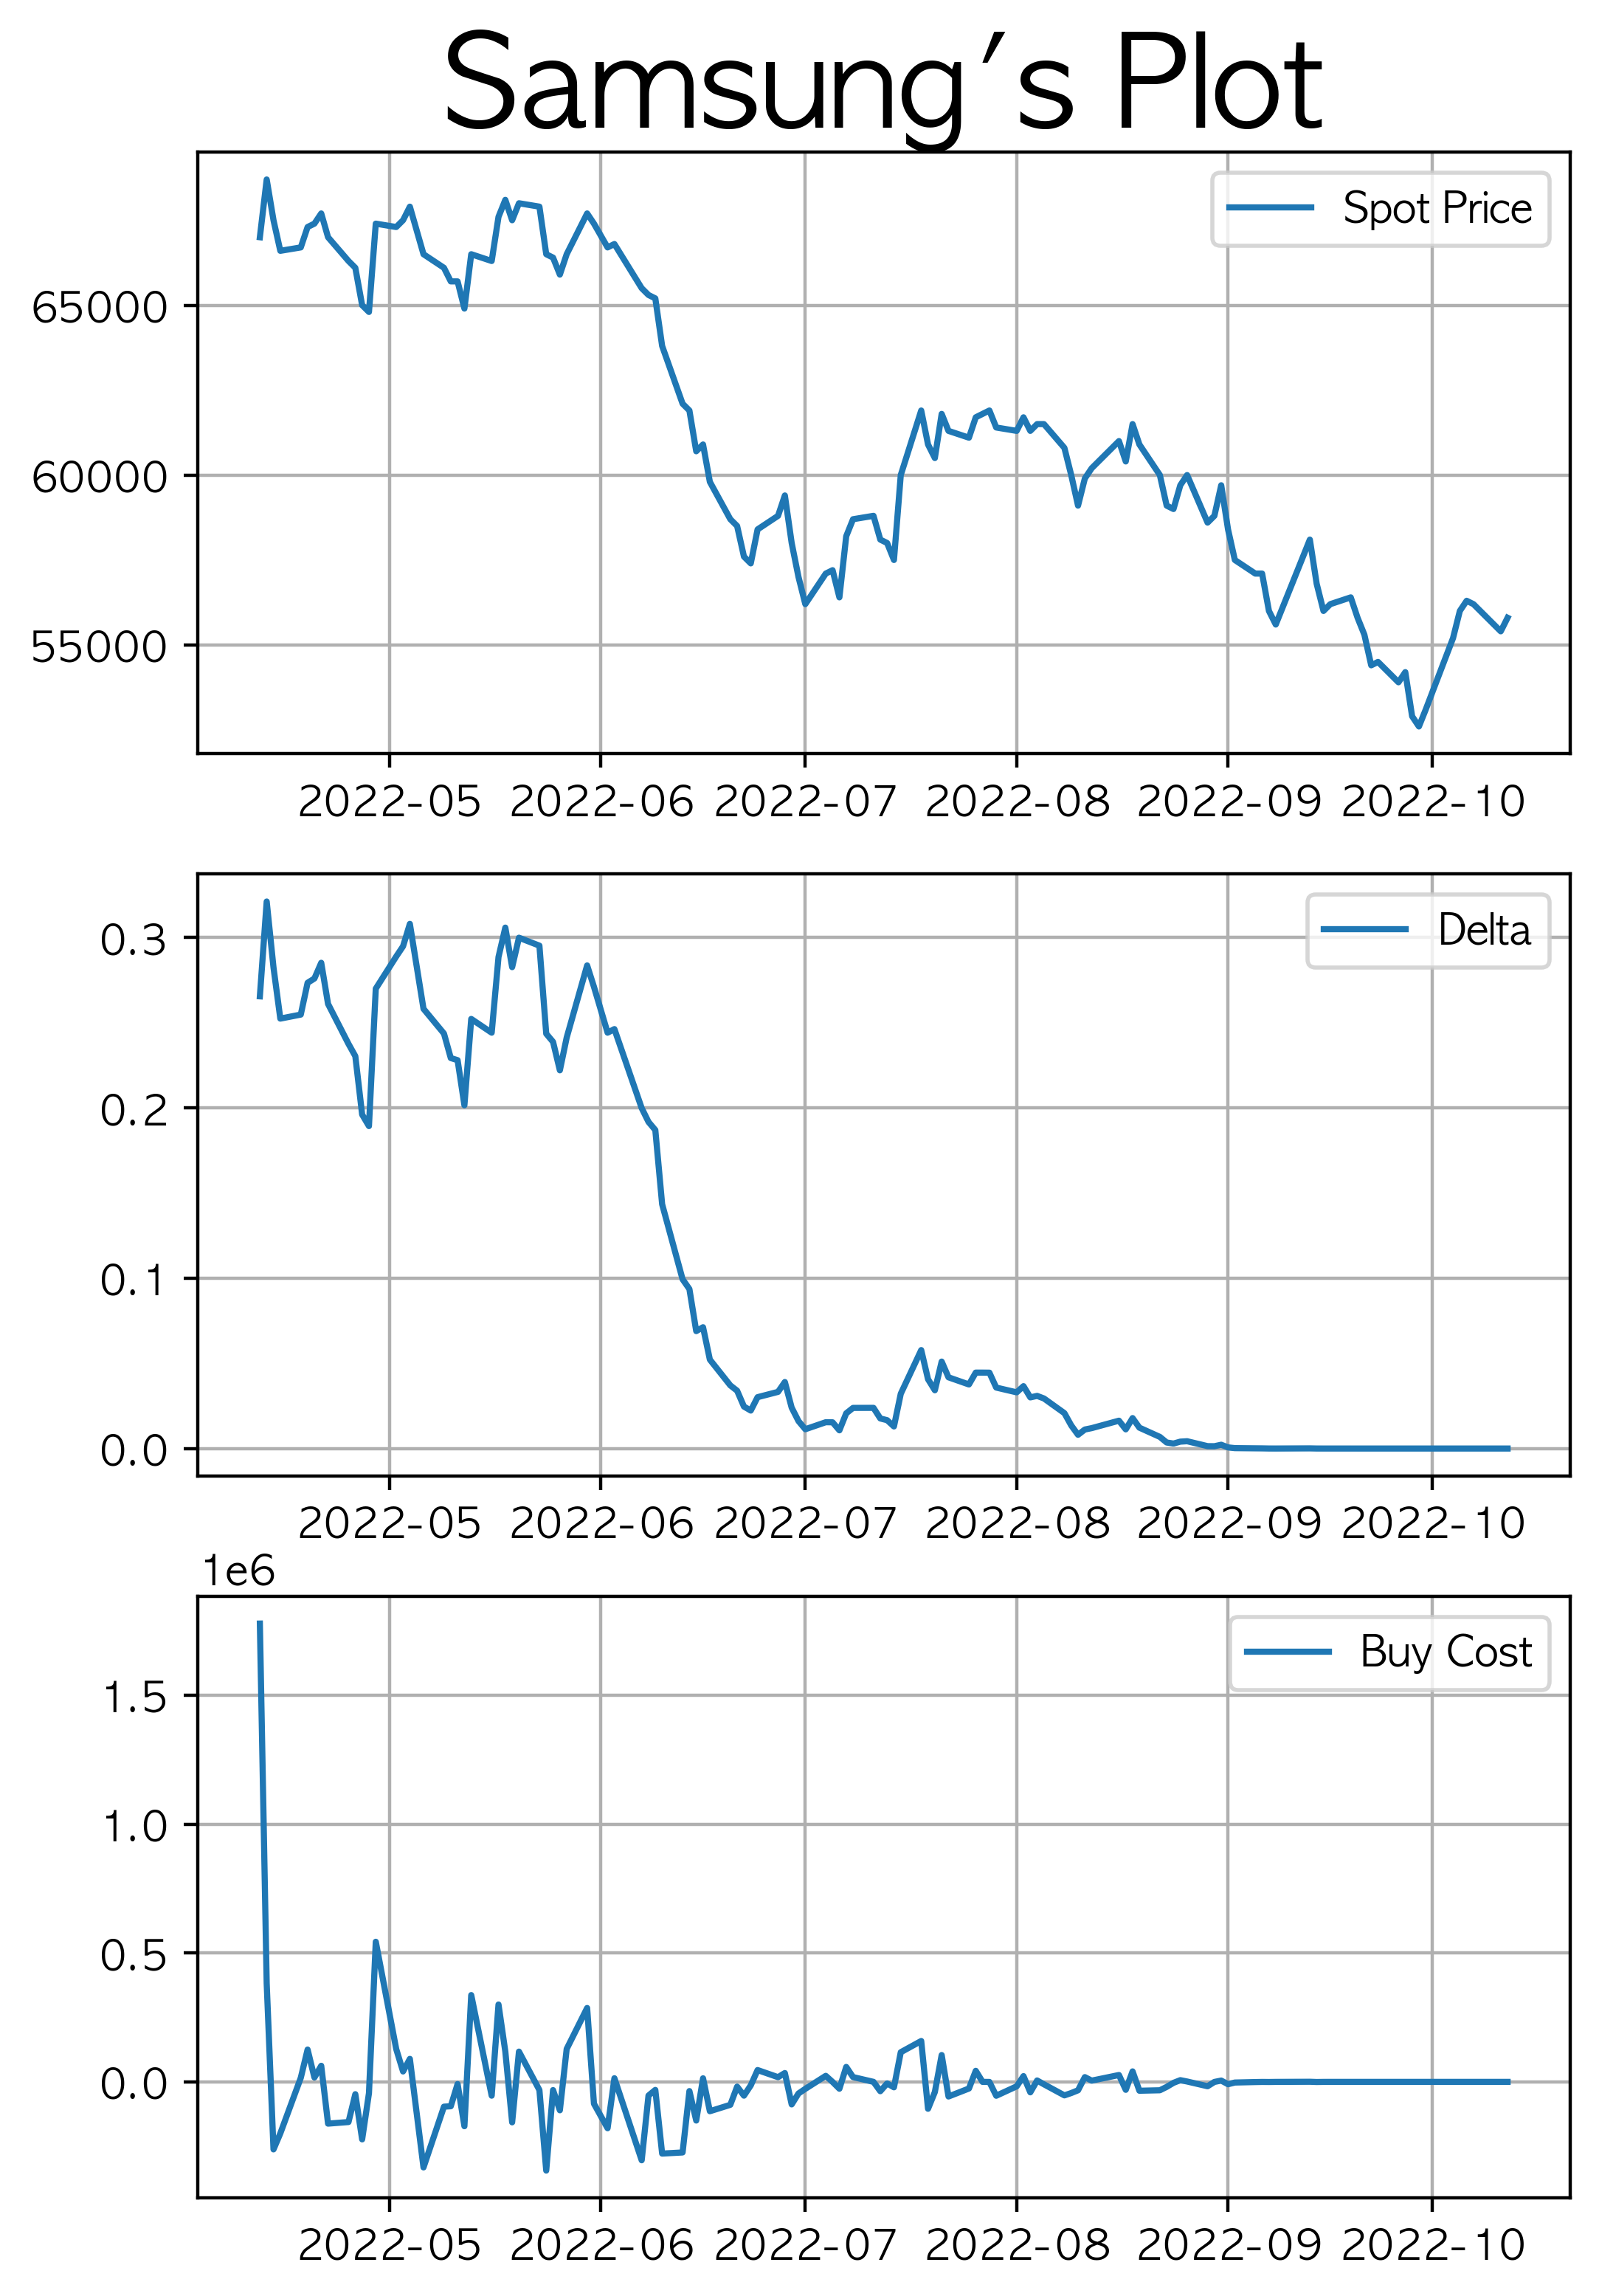

In [688]:
rdh.normal_result_plot()

In [689]:
delta_2_path = rdh.normal_result_df().Delta.to_numpy().reshape(-1,1)/2

np.round(rdh.test_result_df(delta_2_path),3)

,s0,Delta,Delta_test,Delta_ch,Buy Shares_ch,Buy_cost_ch/1000,Buy_cost_with_0.001_ch/1000,Cum_cost/1000,int_cost
2022-04-12,67000.0,0.266,0.133,0.133,13276.725,889540.604,889540.604,889540.604,143474.291
2022-04-13,68700.0,0.321,0.161,0.028,2783.975,191259.049,191259.049,1080943.127,143474.291
2022-04-14,67500.0,0.282,0.141,-0.019,-1939.299,-130902.655,-131033.557,950083.916,174345.666
2022-04-15,66600.0,0.252,0.126,-0.015,-1498.651,-99810.175,-99909.986,850327.169,153239.341
2022-04-18,66700.0,0.255,0.127,0.001,118.305,7890.955,7890.955,858355.274,137149.543
...,...,...,...,...,...,...,...,...,...
2022-10-05,56000.0,0.000,0.000,-0.000,-0.000,-0.000,-0.000,92801.500,14965.570
2022-10-06,56300.0,0.000,0.000,-0.000,-0.000,-0.000,-0.000,92816.468,14967.984
2022-10-07,56200.0,0.000,0.000,-0.000,-0.000,-0.000,-0.000,92831.438,14970.398
2022-10-11,55400.0,0.000,0.000,-0.000,-0.000,-0.000,-0.000,92846.411,14972.813


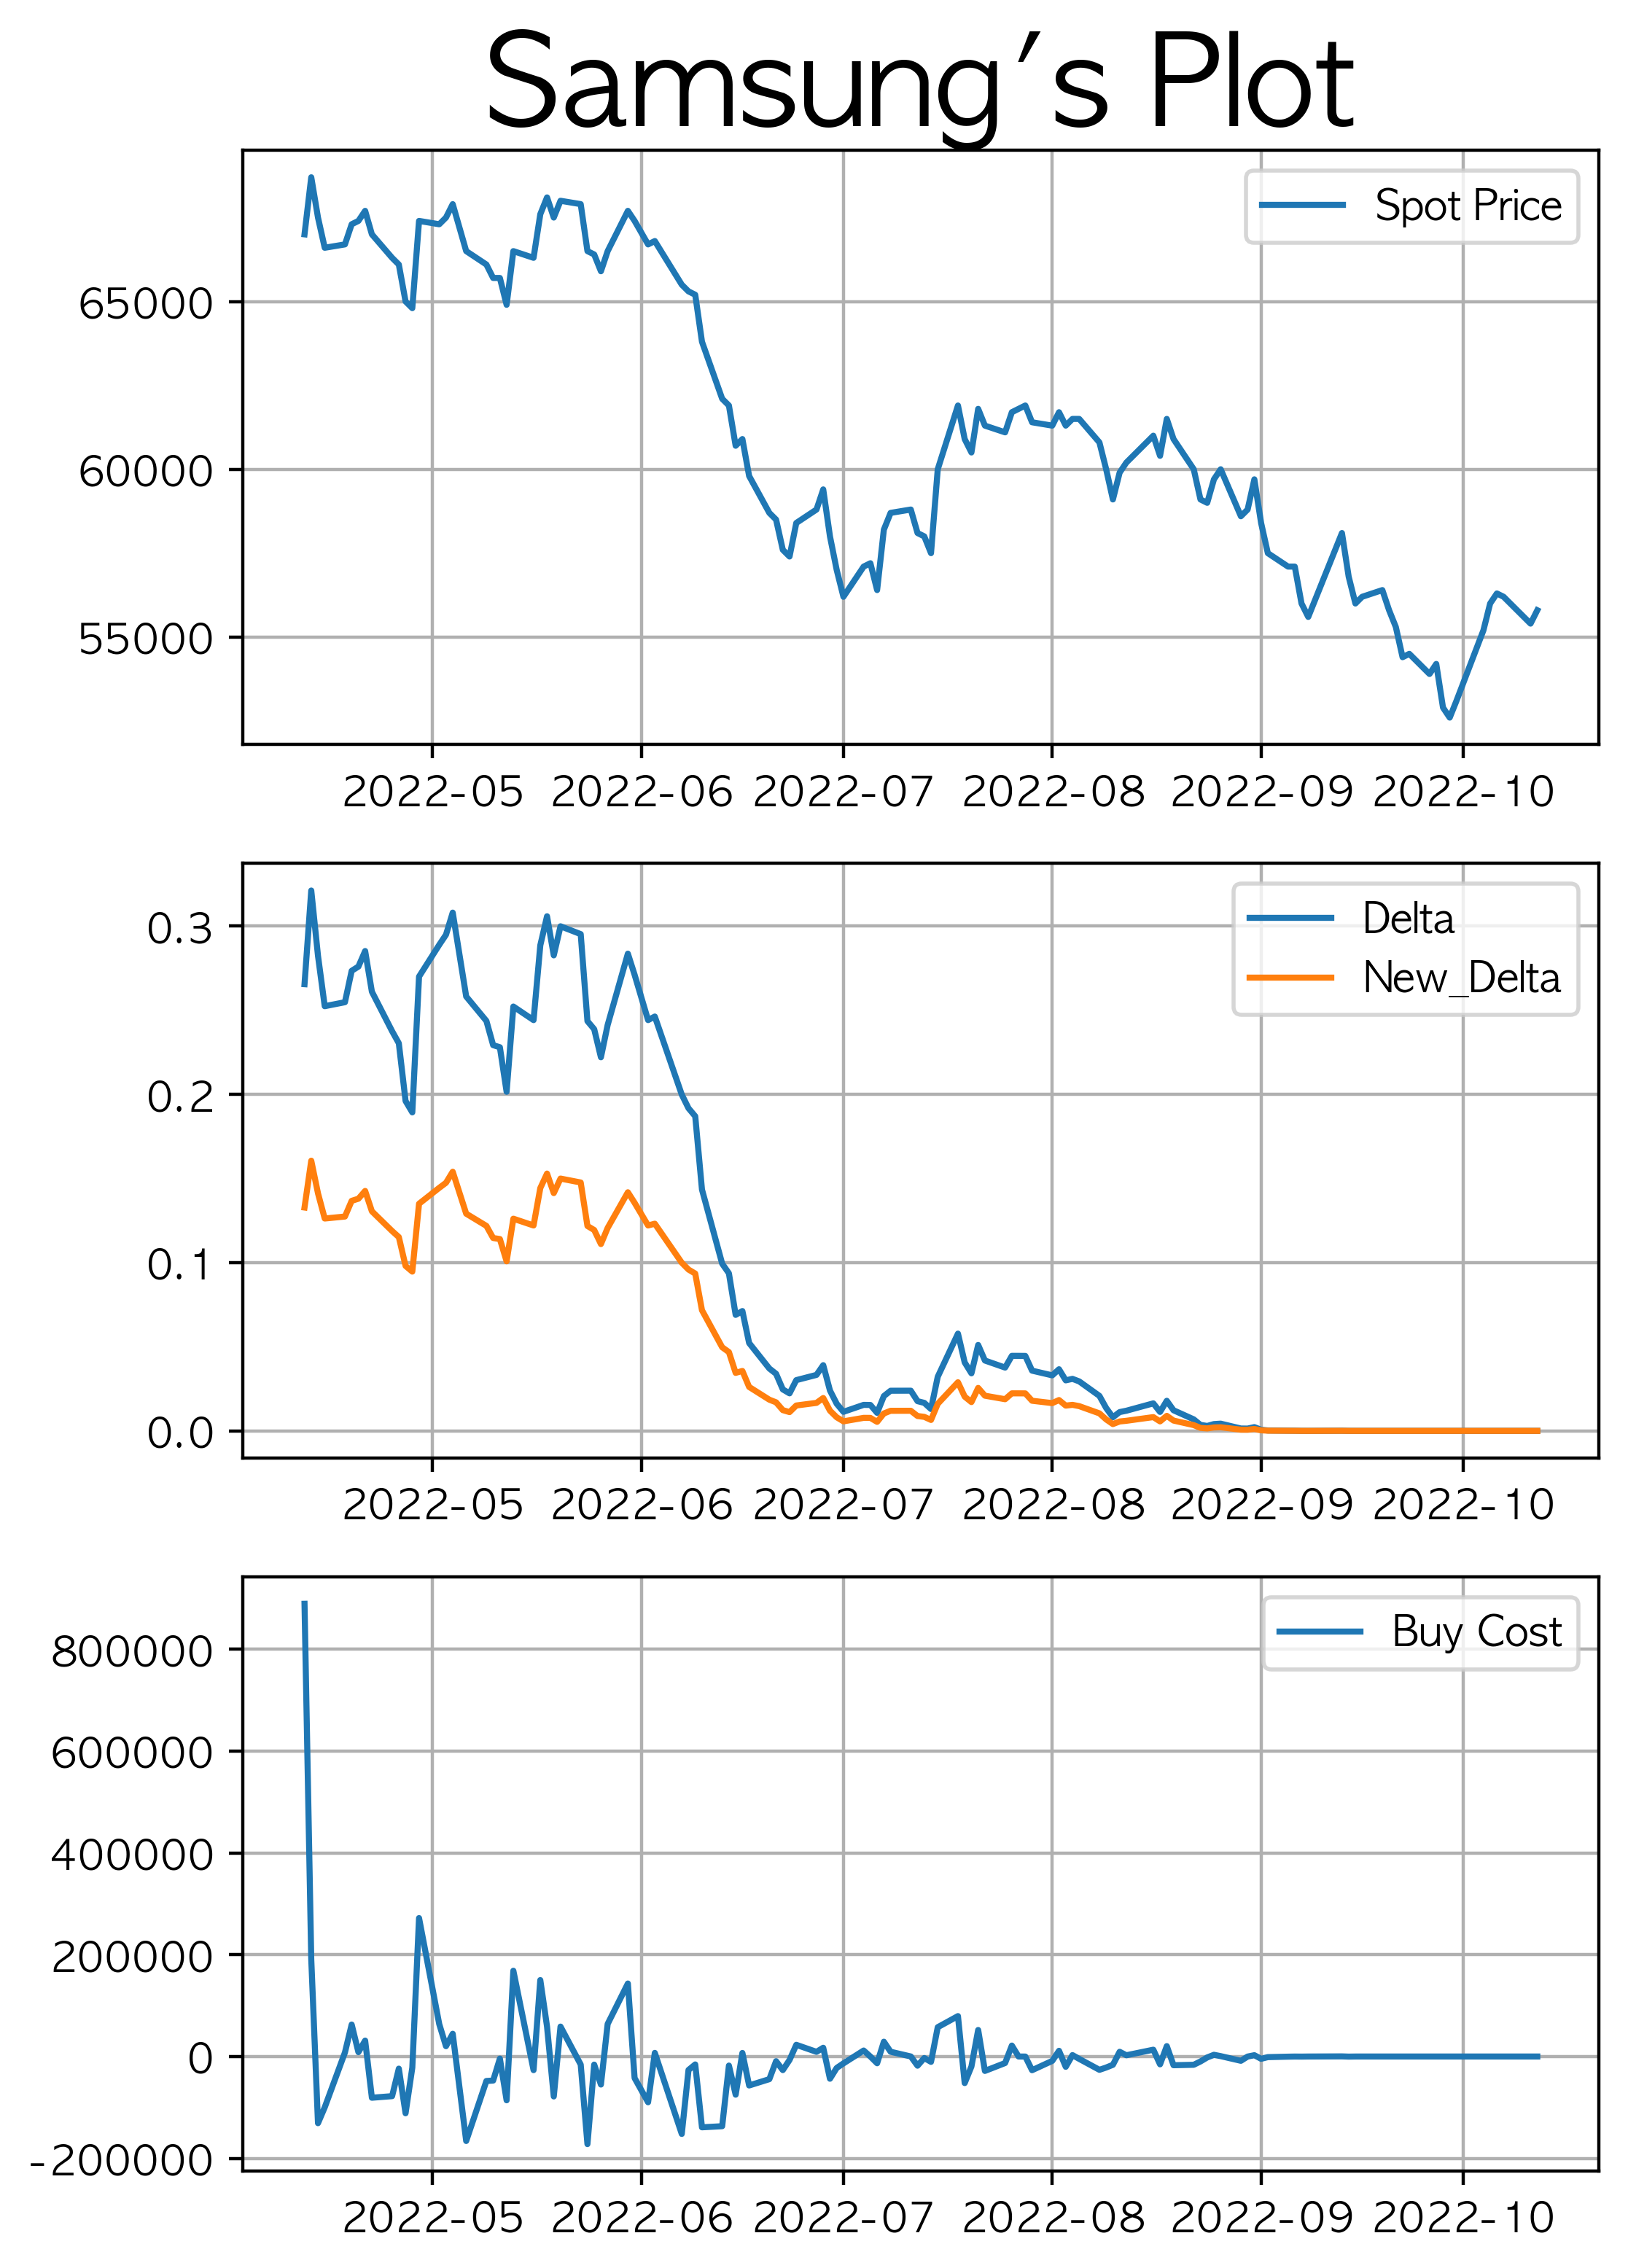

In [691]:
rdh.test_result_plot(delta_2_path)

# Kospi200 의 경우

In [692]:
'''Asset 2 : 코스피 200'''
asset2_1 = stock.get_index_ohlcv('20100414', '20221204', '1028')
asset2_2 = stock.get_index_fundamental('20100414', '20221204', '1028')

hist_vol2 = (np.log(asset2_1[['종가']]).diff().dropna().rolling(124).std() * np.sqrt(252)).dropna().rename(columns={'종가':'vol'})

tau = pd.Series(np.flip(np.arange(1, len(asset2_1.loc[s_date:e_date])+1)), index=asset2_1.loc[s_date:e_date].index, name='tau')

df2 = pd.concat([asset2_1['종가'], asset2_2['배당수익률']/100, rf, hist_vol2, tau], axis=1).loc[s_date:e_date].rename(columns={'종가': 's0', '배당수익률':'q', 'rf':'r'})
df2.columns.name = 'KOSPI200'
df2.head(5)

KOSPI200,s0,q,r,vol,tau
2022-04-12,352.32,0.0228,0.0151,0.175010,124.0
2022-04-13,359.00,0.0224,0.0151,0.176670,123.0
2022-04-14,357.38,0.0225,0.0172,0.175482,122.0
2022-04-15,353.84,0.0227,0.0172,0.175393,121.0
2022-04-18,353.63,0.0227,0.0172,0.175367,120.0


In [694]:
rdh2 = real_delta_hedging(df2, strike_ratio=0.1, option_premium=0.15, num_shares=100000, cost_int=0.04, sell_cost=0.001)
np.round(rdh2.normal_result_df(),3)

,s0,Delta,Delta_ch,Buy Shares_ch,Buy_cost_ch/1000,Buy_cost_with_0.001_ch/1000,Cum_cost/1000,int_cost
2022-04-12,352.32,0.266,0.266,26578.375,9364.093,9364.093,9364.093,1510.338
2022-04-13,359.00,0.310,0.045,4465.919,1603.265,1603.265,10968.868,1510.338
2022-04-14,357.38,0.301,-0.010,-962.791,-344.082,-344.426,10626.211,1769.172
2022-04-15,353.84,0.276,-0.025,-2527.594,-894.364,-895.258,9732.667,1713.905
2022-04-18,353.63,0.273,-0.002,-238.102,-84.200,-84.284,9649.953,1569.785
...,...,...,...,...,...,...,...,...
2022-10-05,289.05,0.000,-0.000,-0.000,-0.000,-0.000,769.657,124.118
2022-10-06,291.26,0.000,-0.000,-0.000,-0.000,-0.000,769.781,124.138
2022-10-07,290.41,0.000,-0.000,-0.000,-0.000,-0.000,769.905,124.158
2022-10-11,284.96,0.000,-0.000,-0.000,-0.000,-0.000,770.029,124.178


In [700]:
a = rdh2.simulation(simul=1000)
a.mean(), rdh2.bsm_eq('c')

(6.890790961715804, array([7.47286724]))

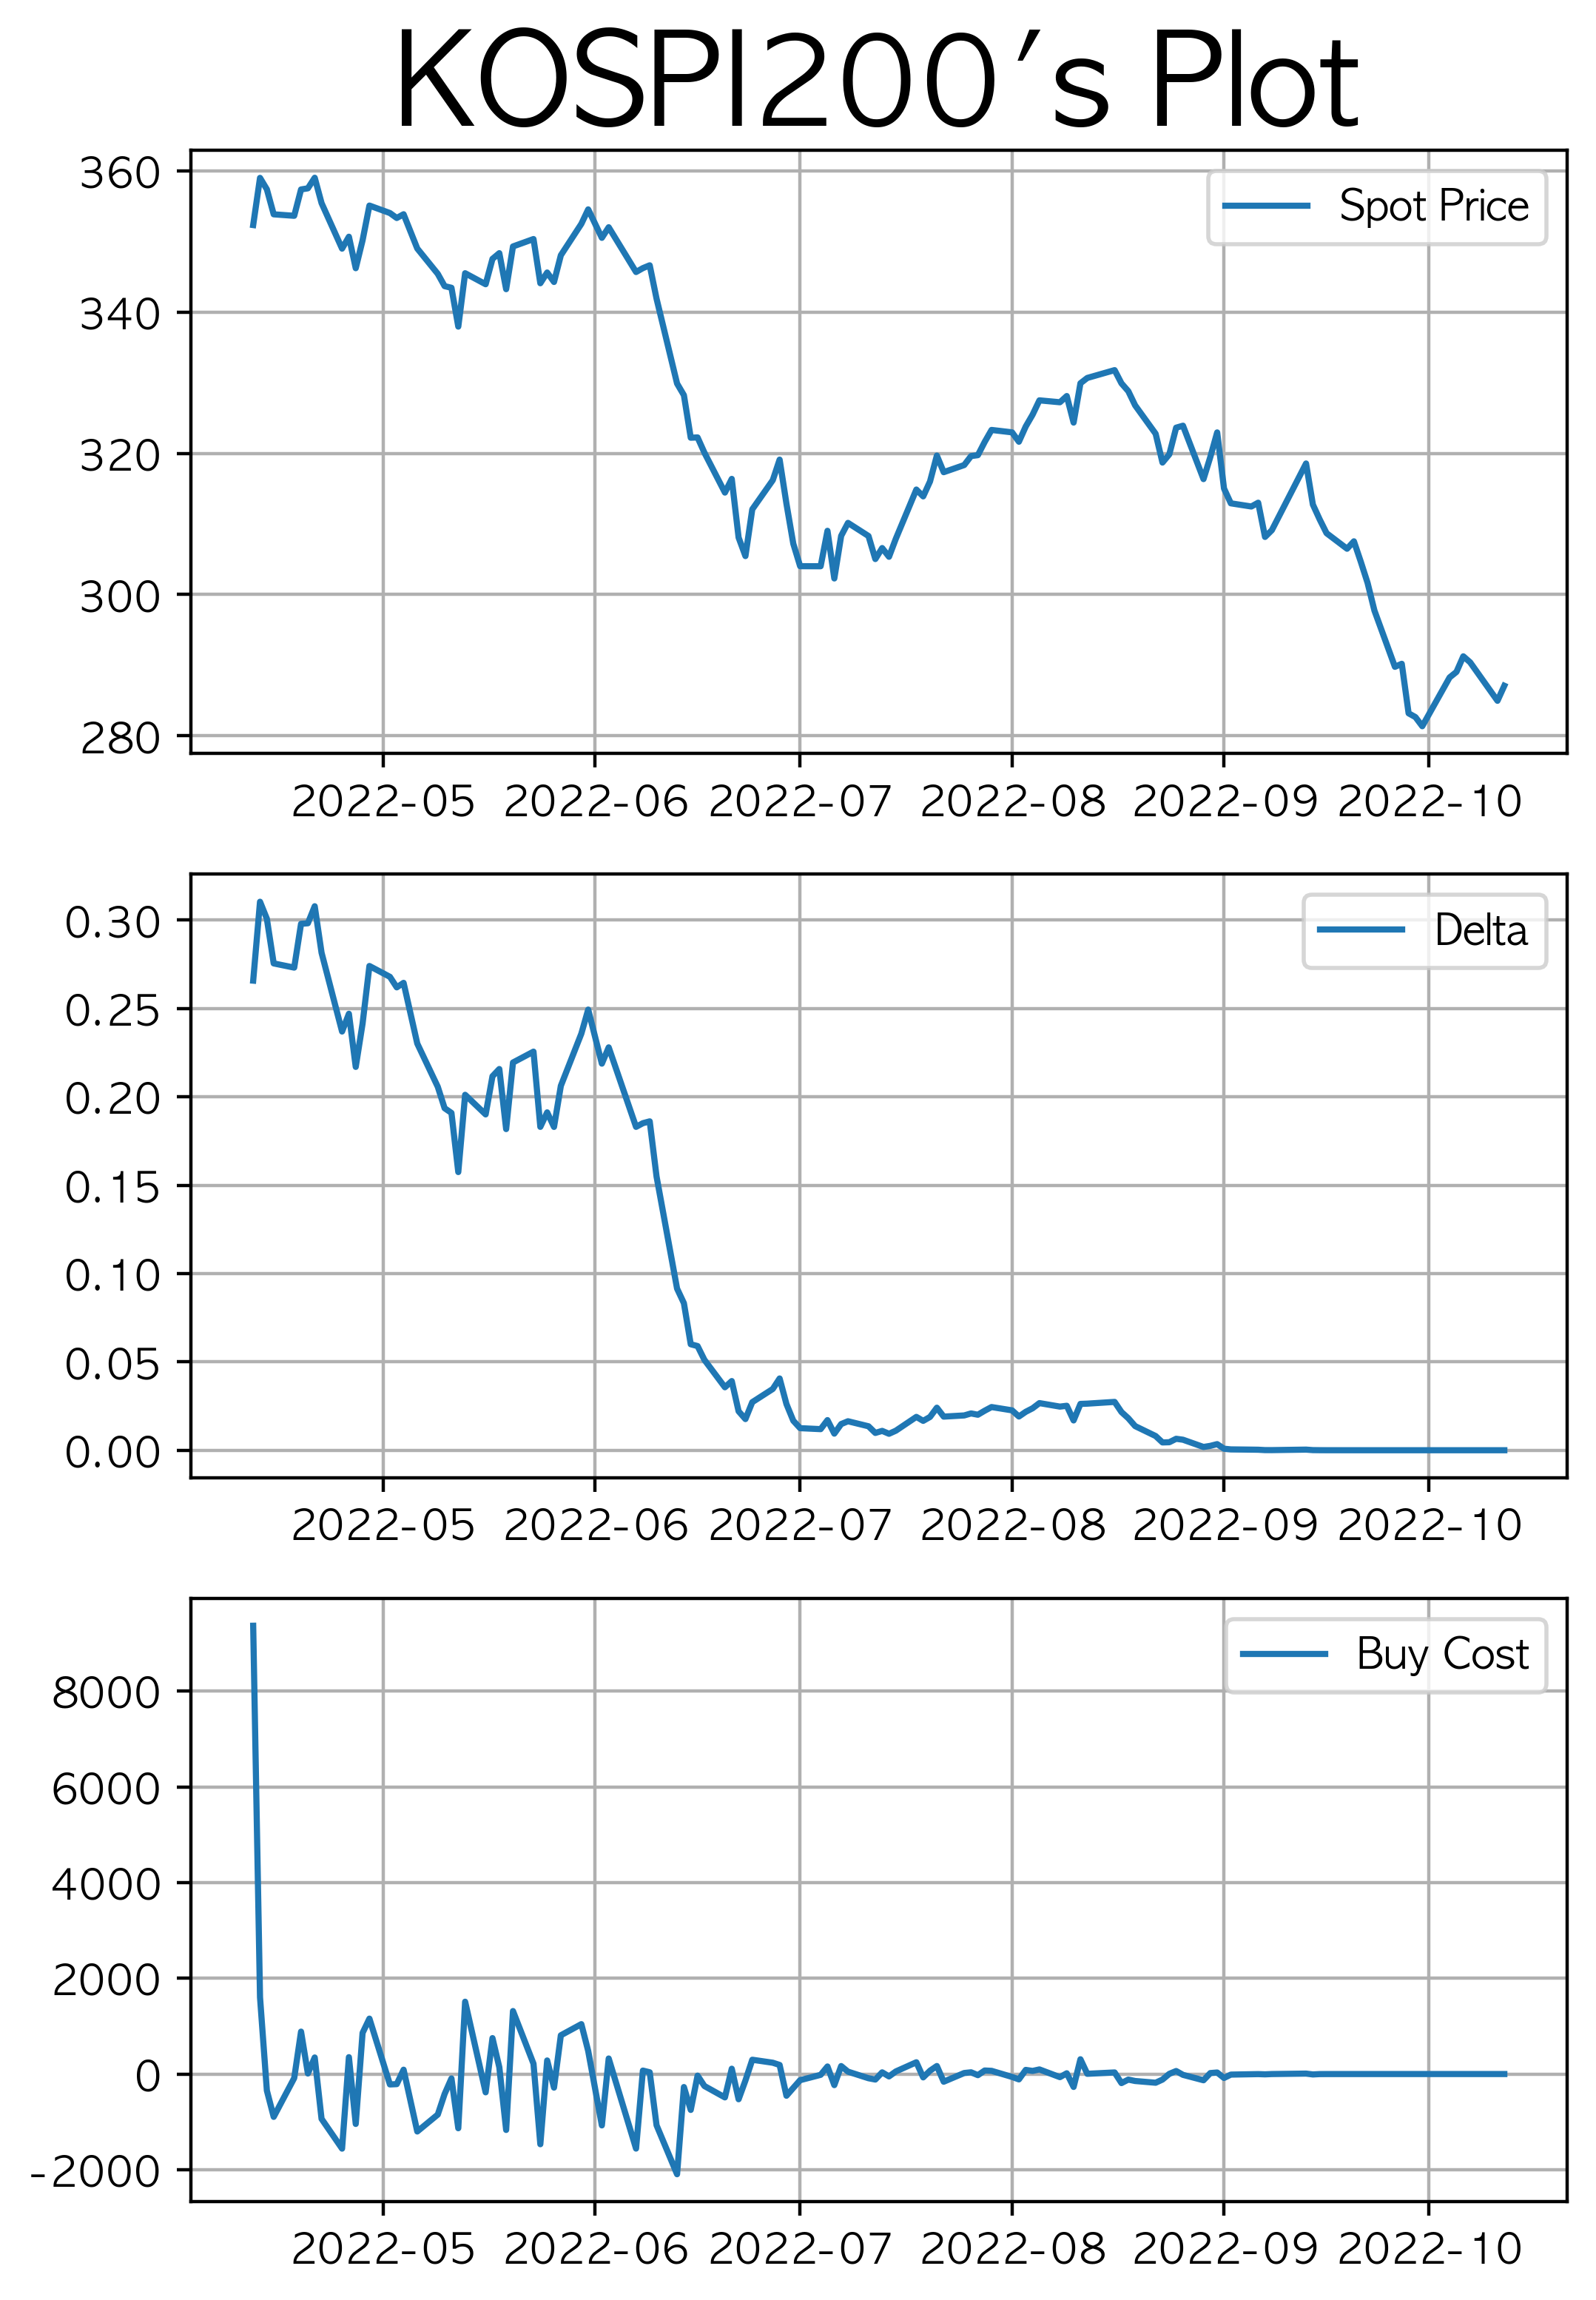

In [701]:
rdh2.normal_result_plot()

# 한국전력

In [702]:
''' Asset 3 : 한국전력 '''
asset3_1 = stock.get_market_ohlcv('20100414', '20221204', '015760')
asset3_2 = stock.get_market_fundamental('20100414', '20221204', '015760')

hist_vol3 = (np.log(asset3_1[['종가']]).diff().dropna().rolling(124).std() * np.sqrt(252)).dropna().rename(columns={'종가':'vol'})

tau = pd.Series(np.flip(np.arange(1, len(asset3_1.loc[s_date:e_date])+1)), index=asset3_1.loc[s_date:e_date].index, name='tau')
df3 = pd.concat([asset3_1['종가'], asset3_2['DIV']/100, rf, hist_vol3, tau], axis=1).loc[s_date:e_date].rename(columns={'종가': 's0', 'DIV':'q', 'rf':'r'})
df3.columns.name = "Korea Electric Power"
df3.head(5)

Korea Electric Power,s0,q,r,vol,tau
2022-04-12,21600.0,0.0563,0.0151,0.270354,124.0
2022-04-13,22100.0,0.0550,0.0151,0.269648,123.0
2022-04-14,21900.0,0.0555,0.0172,0.269878,122.0
2022-04-15,21750.0,0.0559,0.0172,0.269723,121.0
2022-04-18,21850.0,0.0557,0.0172,0.269817,120.0


In [703]:
rdh3 = real_delta_hedging(df3, strike_ratio=0.1, option_premium=0.15, num_shares=100000, cost_int=0.04, sell_cost=0.001)
np.round(rdh3.normal_result_df(),3)

,s0,Delta,Delta_ch,Buy Shares_ch,Buy_cost_ch/1000,Buy_cost_with_0.001_ch/1000,Cum_cost/1000,int_cost
2022-04-12,21600.0,0.338,0.338,33822.446,730564.837,730564.837,730564.837,117833.038
2022-04-13,22100.0,0.378,0.039,3941.809,87113.987,87113.987,817796.657,117833.038
2022-04-14,21900.0,0.363,-0.015,-1491.917,-32672.983,-32705.656,785222.904,131902.687
2022-04-15,21750.0,0.350,-0.013,-1274.152,-27712.810,-27740.523,757609.030,126648.855
2022-04-18,21850.0,0.357,0.007,738.965,16146.376,16146.376,773877.600,122195.005
...,...,...,...,...,...,...,...,...
2022-10-05,19550.0,0.000,-0.000,-11.190,-218.758,-218.976,106816.078,17260.934
2022-10-06,19550.0,0.000,-0.000,-0.545,-10.662,-10.672,106822.635,17228.400
2022-10-07,19350.0,0.000,-0.000,-0.046,-0.897,-0.898,106838.966,17229.457
2022-10-11,18450.0,0.000,-0.000,-0.000,-0.002,-0.002,106856.196,17232.091


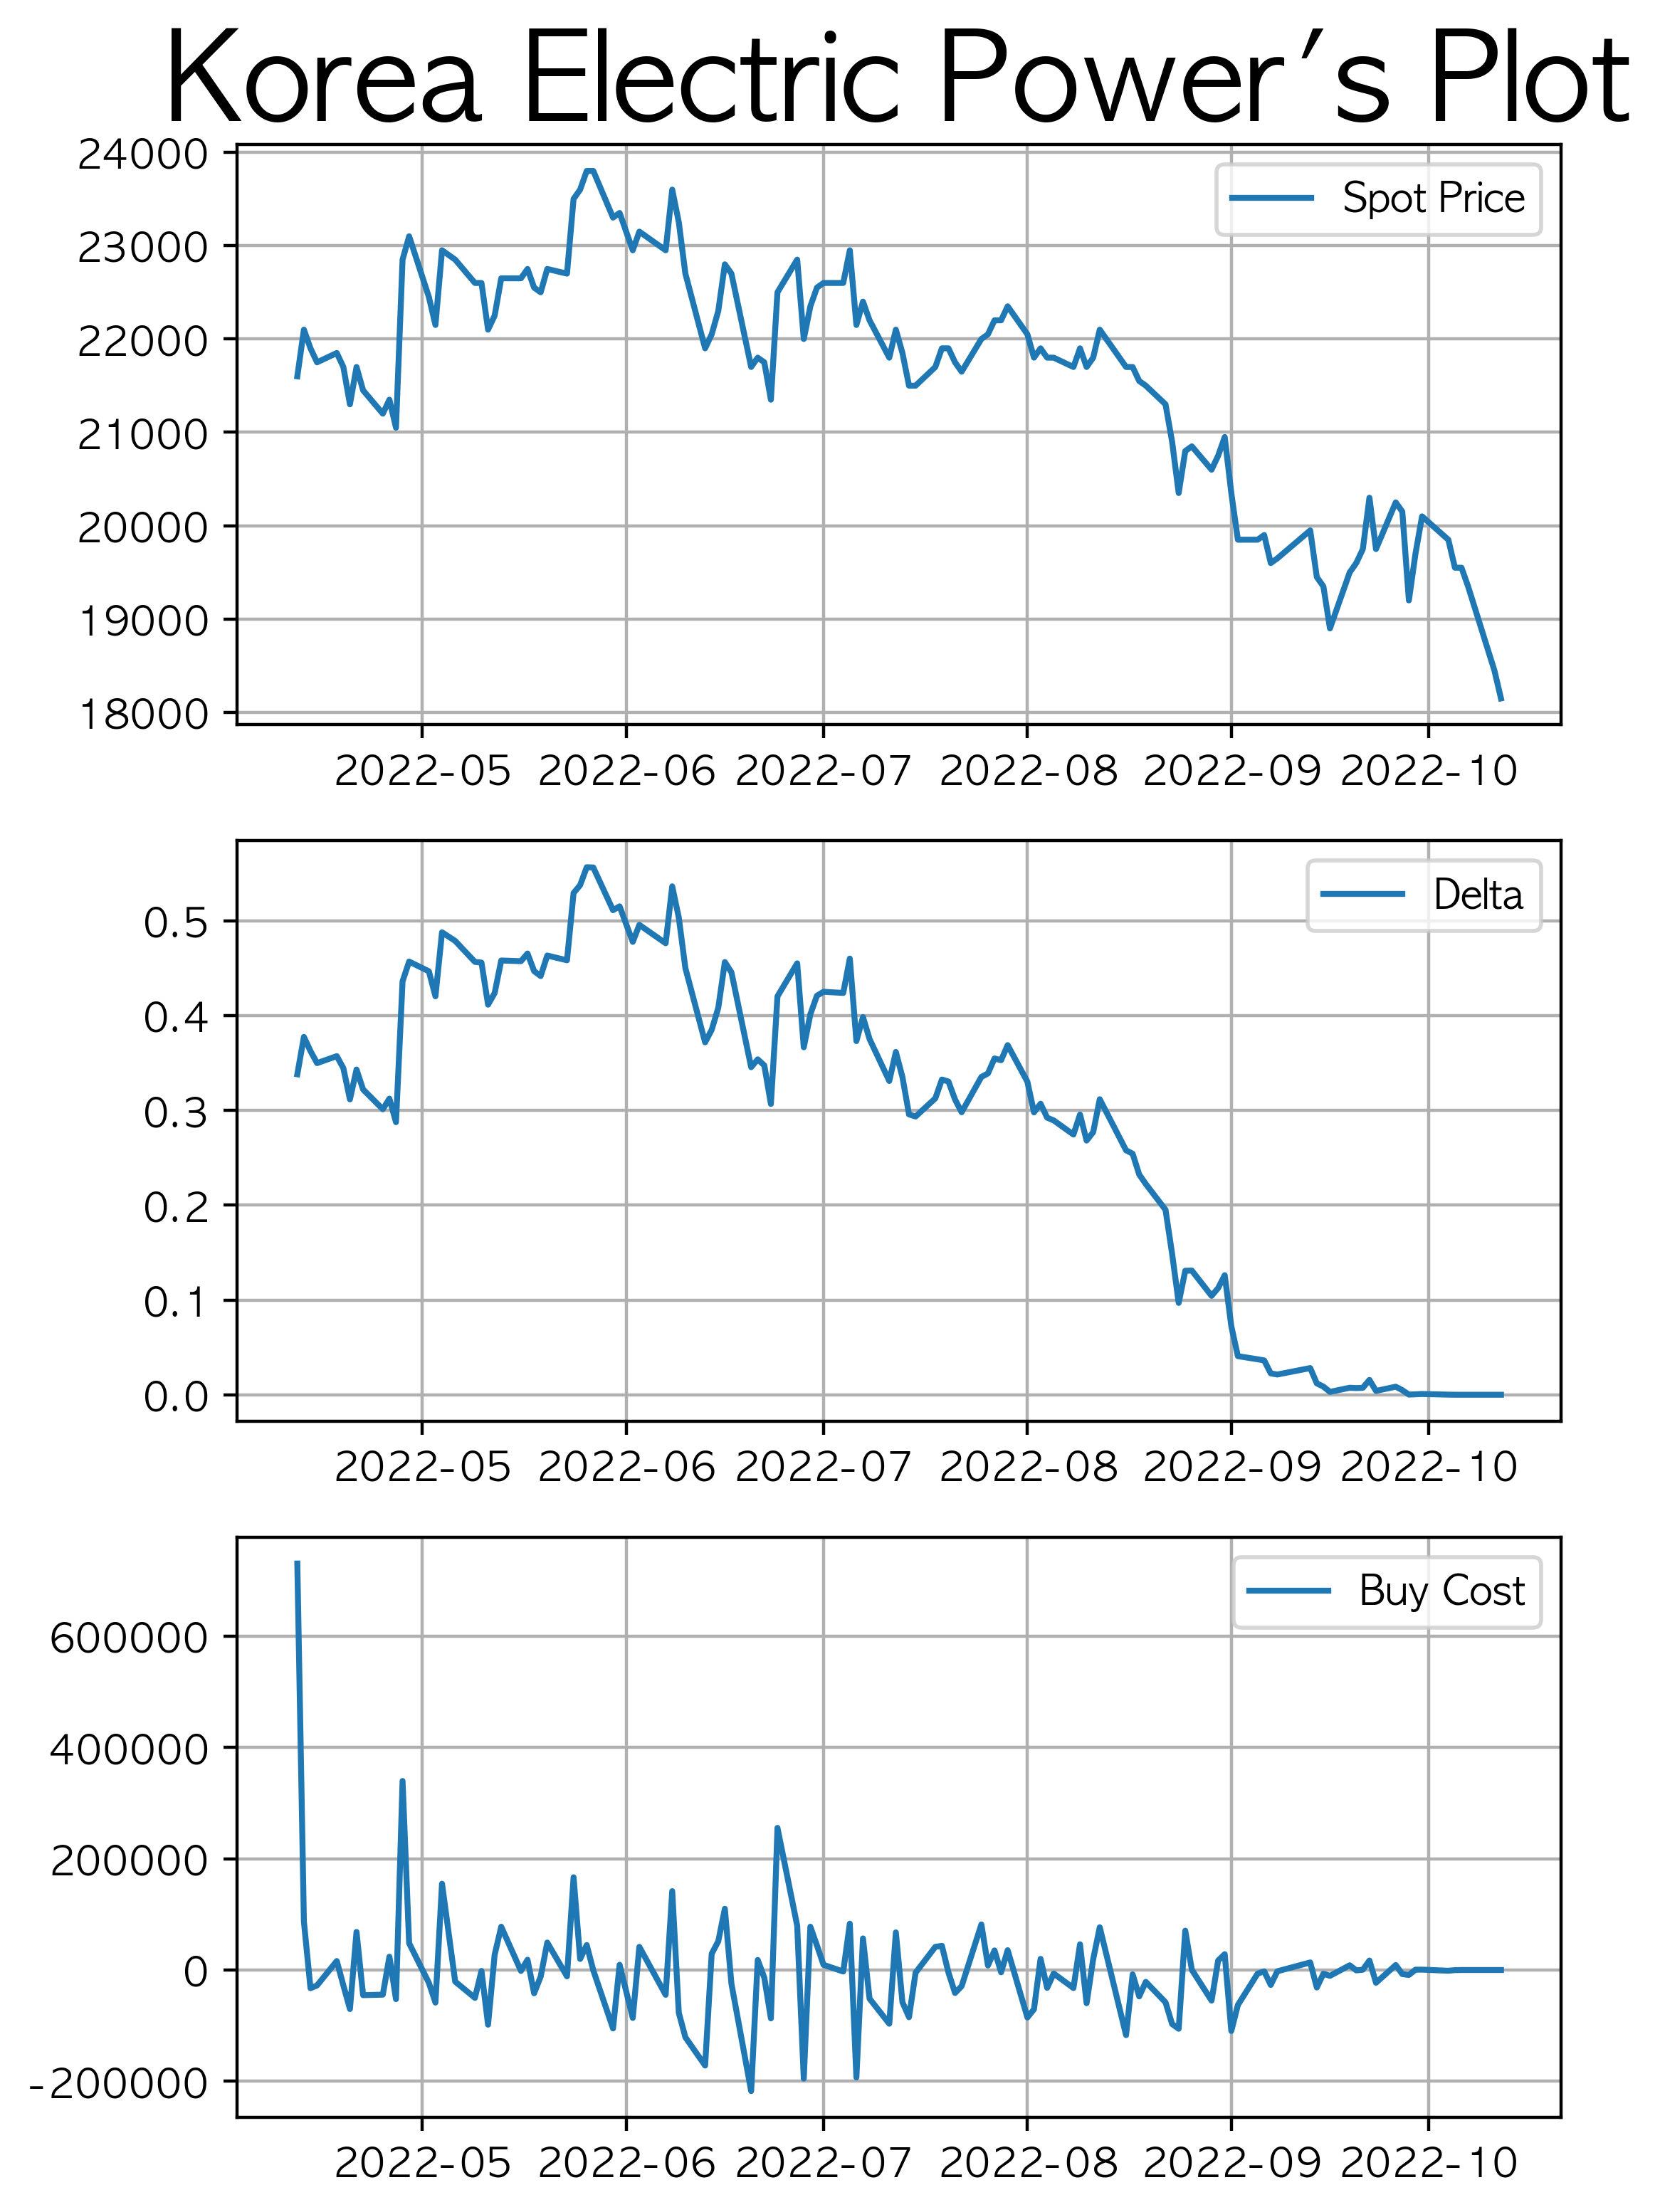

In [704]:
rdh3.normal_result_plot()

# SK 텔레콤

In [705]:
''' Asset 4 : SK 텔레콤 '''
asset4_1 = stock.get_market_ohlcv('20100414', '20221204', '017670')
asset4_2 = stock.get_market_fundamental('20100414', '20221204', '017670')

hist_vol4 = (np.log(asset4_1[['종가']]).diff().dropna().rolling(124).std() * np.sqrt(252)).dropna().rename(columns={'종가':'vol'})

tau = pd.Series(np.flip(np.arange(1, len(asset4_1.loc[s_date:e_date])+1)), index=asset4_1.loc[s_date:e_date].index, name='tau')
df4 = pd.concat([asset4_1['종가'], asset4_2['DIV']/100, rf, hist_vol4, tau], axis=1).loc[s_date:e_date].rename(columns={'종가': 's0', 'DIV':'q', 'rf':'r'})
df4.columns.name = 'SK Telecom'
df4.head(5)

SK Telecom,s0,q,r,vol,tau
2022-04-12,62500.0,0.0320,0.0151,0.267063,124.0
2022-04-13,61500.0,0.0325,0.0151,0.268137,123.0
2022-04-14,60500.0,0.0331,0.0172,0.269318,122.0
2022-04-15,59500.0,0.0336,0.0172,0.270186,121.0
2022-04-18,59800.0,0.0334,0.0172,0.269430,120.0


In [706]:
rdh4 = real_delta_hedging(df4, strike_ratio=0.1, option_premium=0.15, num_shares=100000, cost_int=0.04, sell_cost=0.001)
np.round(rdh4.normal_result_df(),3)

,s0,Delta,Delta_ch,Buy Shares_ch,Buy_cost_ch/1000,Buy_cost_with_0.001_ch/1000,Cum_cost/1000,int_cost
2022-04-12,62500.0,0.356,0.356,35598.806,2224925.351,2224925.351,2224925.351,358858.928
2022-04-13,61500.0,0.327,-0.029,-2854.497,-175551.592,-175727.144,2049557.066,358858.928
2022-04-14,60500.0,0.301,-0.027,-2662.519,-161082.374,-161243.457,1888644.183,330573.720
2022-04-15,59500.0,0.273,-0.028,-2776.974,-165229.980,-165395.210,1723553.593,304620.030
2022-04-18,59800.0,0.280,0.007,699.413,41824.892,41824.892,1765656.478,277992.515
...,...,...,...,...,...,...,...,...
2022-10-05,50900.0,0.000,-0.000,-0.000,-0.001,-0.001,254503.371,41042.311
2022-10-06,50500.0,0.000,-0.000,-0.000,-0.000,-0.000,254544.420,41048.931
2022-10-07,50200.0,0.000,-0.000,-0.000,-0.000,-0.000,254585.476,41055.552
2022-10-11,48700.0,0.000,-0.000,-0.000,-0.000,-0.000,254626.538,41062.173


In [710]:
rdh4.path_changes(rdh4.path_delta())

array([[ 3.55988056e-01],
       [-2.85449744e-02],
       [-2.66251859e-02],
       [-2.77697446e-02],
       [ 6.99412913e-03],
       [ 1.51970632e-02],
       [ 2.39122386e-02],
       [ 1.87534637e-02],
       [-1.22207438e-02],
       [-5.63064209e-02],
       [-1.70670194e-02],
       [-5.65704891e-02],
       [-3.61160562e-03],
       [ 5.96754606e-03],
       [-4.65987759e-02],
       [ 1.65771051e-02],
       [ 8.24408116e-03],
       [-9.97538287e-03],
       [ 5.93654509e-03],
       [ 2.28213693e-02],
       [ 1.15992371e-02],
       [ 4.18158324e-03],
       [ 3.08120911e-02],
       [-5.01232366e-02],
       [ 3.50423575e-02],
       [-4.42350092e-02],
       [-2.43670925e-02],
       [ 8.20691418e-03],
       [-2.11439757e-02],
       [-1.78578092e-02],
       [-3.03370621e-03],
       [ 1.22850701e-02],
       [ 3.23116510e-03],
       [-3.23042907e-03],
       [-1.08799057e-03],
       [-1.96194546e-02],
       [ 6.90390177e-03],
       [-9.10815405e-03],
       [-3.0

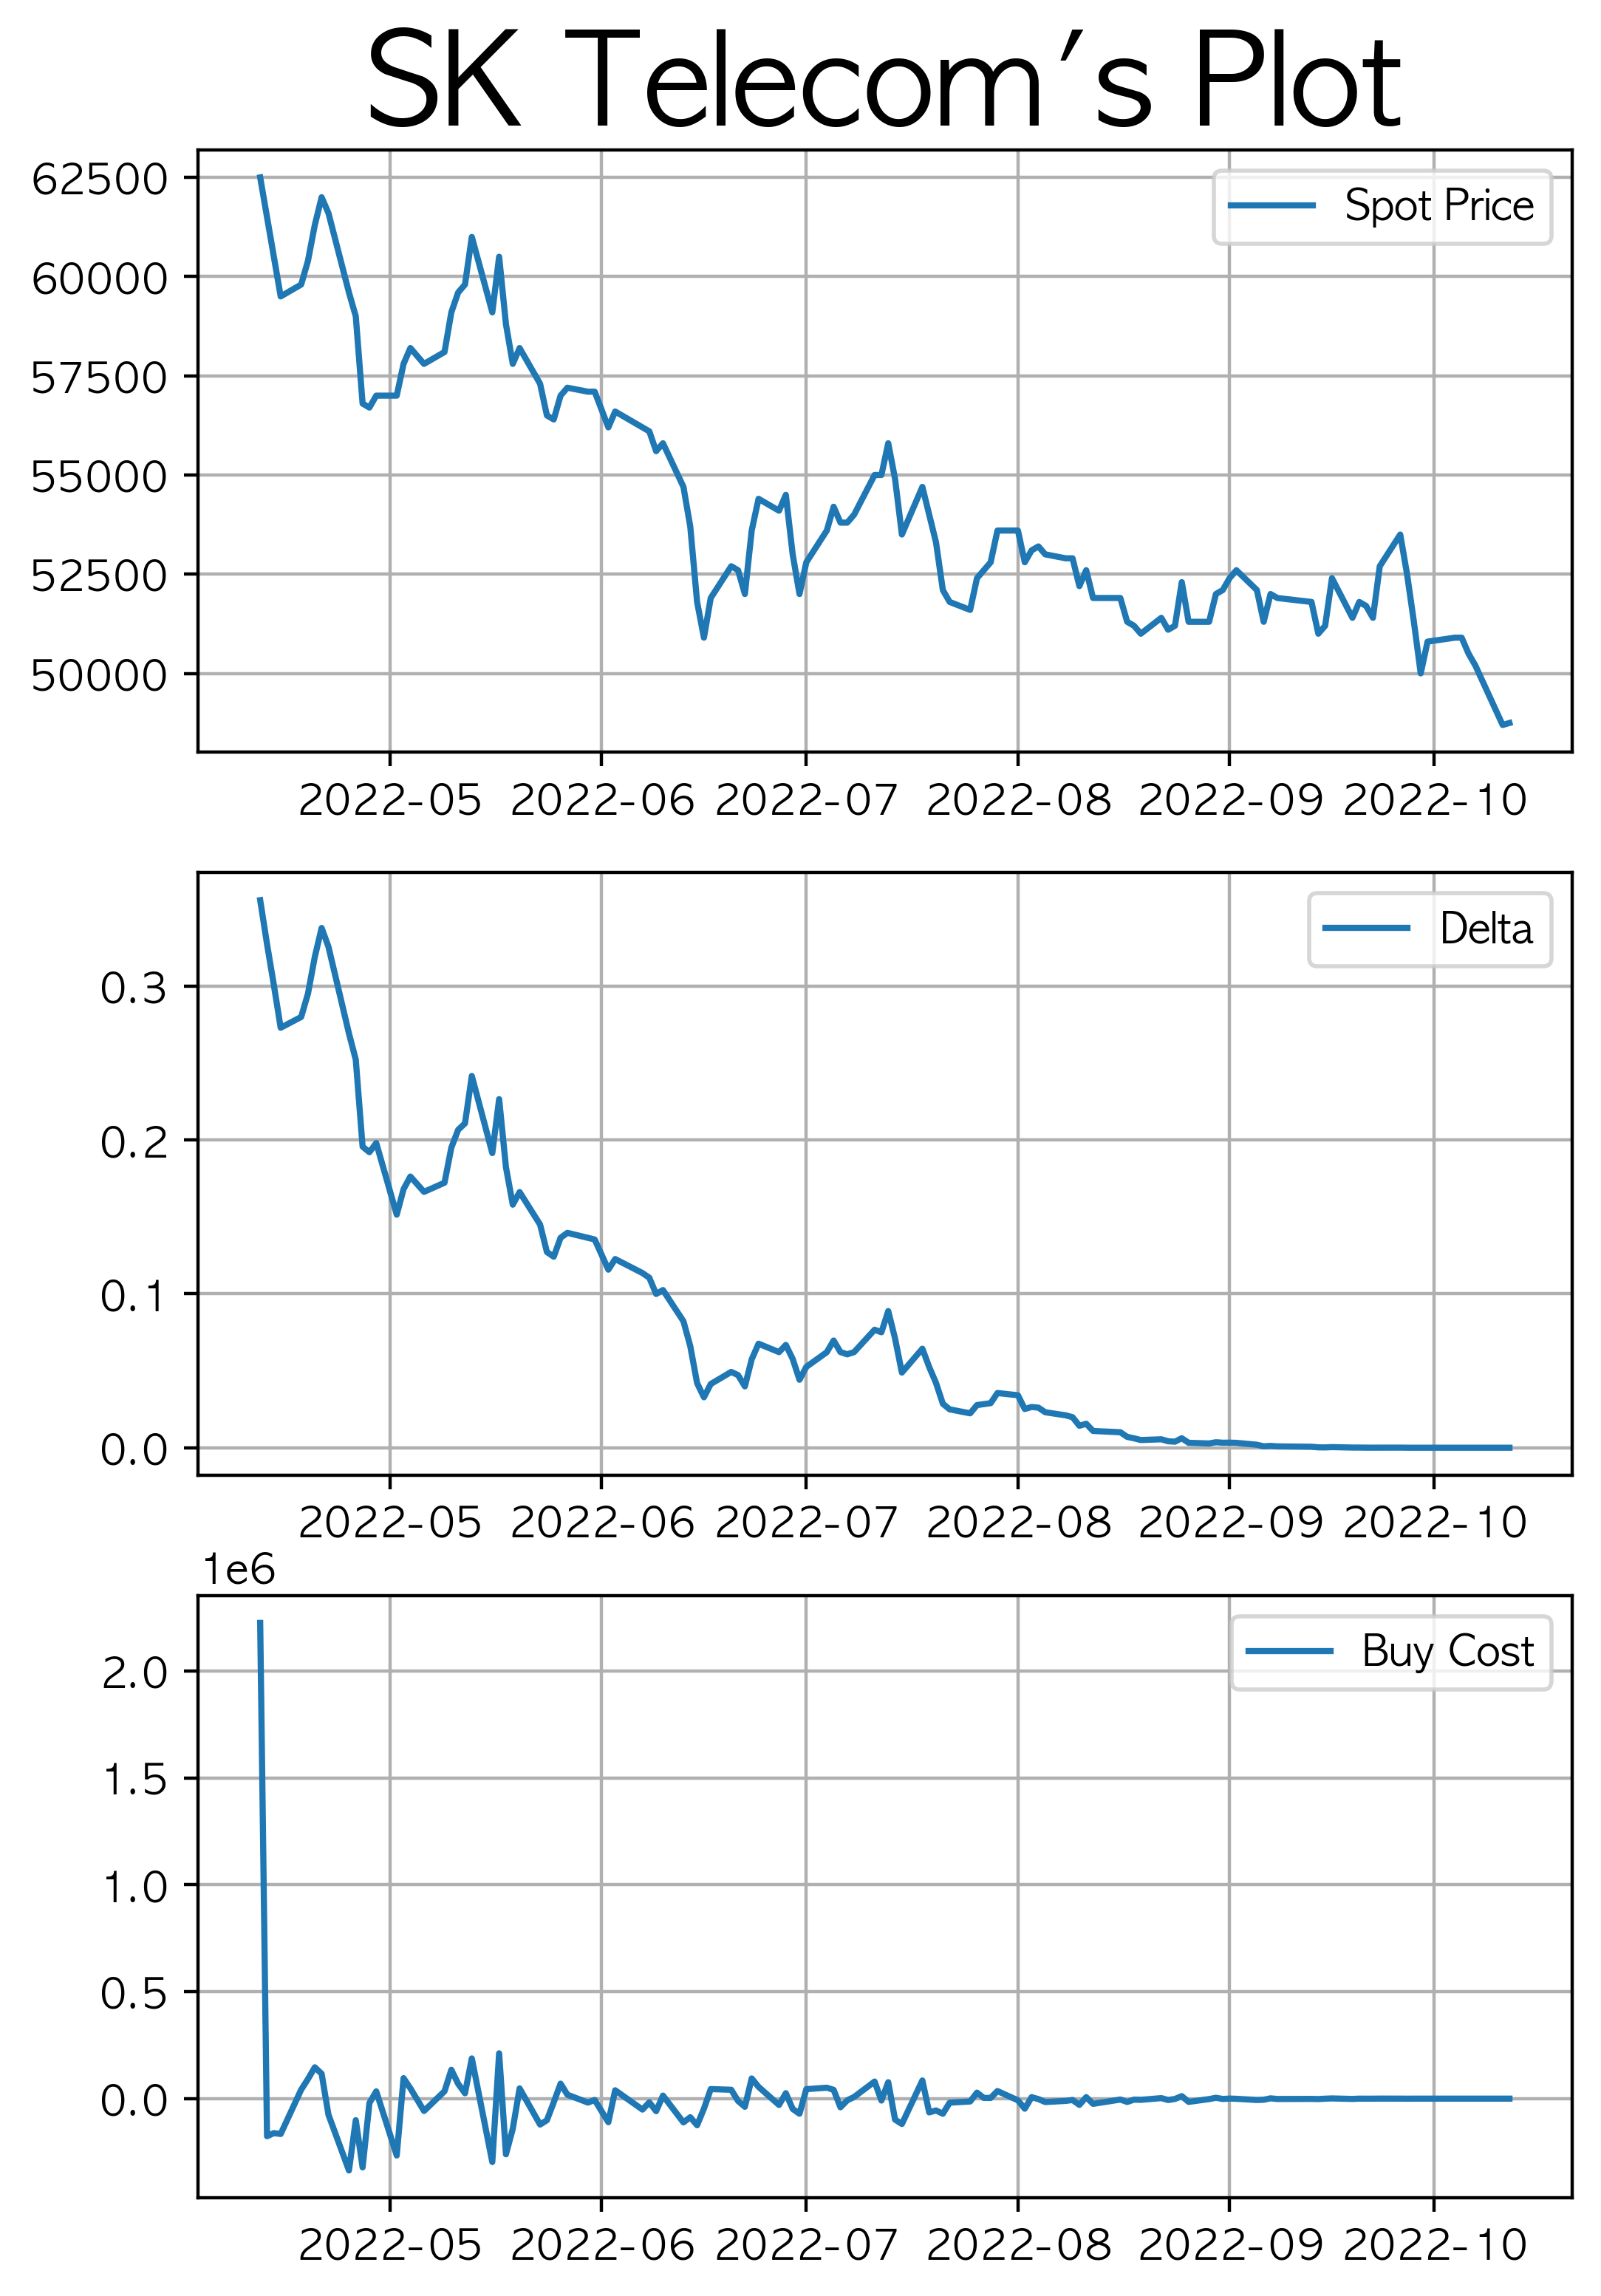

In [707]:
rdh4.normal_result_plot()